In [60]:
%load_ext autoreload
%autoreload 2

from os.path import basename
from pprint import pprint
from glob import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)

import spacy
import re
import textacy
import gensim

from tqdm import tqdm_notebook as tqdm

from wordcloud import WordCloud

import scattertext as st
import json

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [63]:
nlp = spacy.en.English()

# Load datasets 

In [116]:
project_files = glob('../../data/projects-2014-2017/*.json')

In [117]:
project_files

['../../data/projects-2014-2017/2016-12-03-projects-wbo2014-lemmatized.json',
 '../../data/projects-2014-2017/2016-12-03-projects-wbo2015-lemmatized.json',
 '../../data/projects-2014-2017/2017-08-30-projects-wbo2017-lemmatized.json',
 '../../data/projects-2014-2017/2016-12-03-projects-wbo2016-lemmatized.json']

In [118]:
prjs = []
for project_file in tqdm(project_files):
    year = basename(project_file).split('-')[4][3:]
    print(year)
    with open(project_file, 'r') as fo:
        df = pd.DataFrame.from_dict(json.load(fo), orient='index')
        df['Year'] = int(year)
    prjs.append(df)
    
df_projects = pd.concat(prjs)

2014
2015
2017
2016


In [119]:
df = pd.DataFrame.from_dict(projects, orient='index')

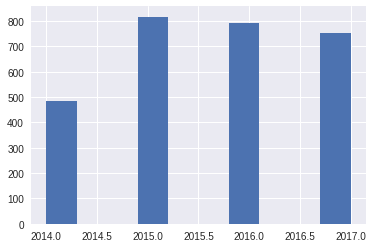

In [120]:
df_projects.Year.hist()

In [121]:
df_projects.sample(5)

,Year,attachments,budget,budget_integer,category,comments,description,description-lemmatized,detailed_localization,detailed_location,...,points,positions,region,region_no,status,threshold,title,title-lemmatized,url,votes
438,2017,NaN,500 000 zł,500000.0,komunikacja zbiorowa,NaN,Przystosowanie torowiska tramwajowego to porus...,"[przystosować, torowisko, tramwajowy, to, poru...",NaN,brak.,...,NaN,"[[17.0587420463562, 51.12976106226297], [17.05...",projekt ogólnomiejski,ogólnomiejski,NaN,do 1 000 000 zł,Tram-Buspas na Mostach Warszawskich,"[trama, -, buspas, na, most, warszawski]",https://www.wroclaw.pl/budzet-obywatelski-wroc...,NaN
624,2015,[[http://www.wroclaw.pl/budzet-obywatelski-wro...,100000,NaN,place zabaw,"[[Komentarz UMW po II etapie weryfikacji:, Pro...",Poniższy projekt zgłaszany jest w imieniu Rady...,"[poniå¼szy, projekt, zgåaszany, być, w, imien...","1. Wrocław Park Langiewicza -Grabiszyn AR_17,20",NaN,...,"[{'longitude': 17.00605568227843, 'latitude': ...",NaN,NaN,NaN,Nie wybrany w głosowaniu,NaN,"Raz, dwa, trzy. Huśtam się ja, huśtasz się TY....","[raz, ,, dwa, ,, trzy, ., huåtam, siä, ja, ,...",NaN,218.0
442,2015,[[http://www.wroclaw.pl/budzet-obywatelski-wro...,2000000,NaN,rewitalizacja,"[[Komentarz UMW po II etapie weryfikacji:, Pro...",Cel:\r\nCelem przedstawionego projektu jest st...,"[cel, :, cel, przedstawić, projekt, być, stwor...","Okolice stadionu MOSiR ul. Lotnicza, pomiędzy ...",NaN,...,"[{'longitude': 16.95672241268926, 'latitude': ...",NaN,NaN,NaN,Nie wybrany w głosowaniu,NaN,Budowa strefy sportów miejskich pomiędzy ul. ...,"[budowa, strefa, sportã³w, miejski, pomiädzy,...",NaN,853.0
58,2017,NaN,1 000 000 zł,1000000.0,piesze/rowerowe,NaN,Po ostatniej zmianie organizacji ruchu w tym r...,"[po, ostatni, zmiana, organizacja, Ruch, ruch,...",NaN,"Ul. Racławicka, rondo Racławicka / Gajowicka",...,NaN,"[[17.00292259454727, 51.082279303260805], [17....",projekt ogólnomiejski,ogólnomiejski,NaN,do 1 000 000 zł,Przebudowa ronda na ul. Gajowickiej/Racławicki...,"[przebudowa, rondo, na, ulica, ., gajowickiej,...",https://www.wroclaw.pl/budzet-obywatelski-wroc...,NaN
346,2015,[],98000,NaN,edukacja,[],Teren boiska wymaga odnowienia. Od kilkunastu ...,"[teren, boisko, wymagać, odnowić, ., od, kilka...","STARE MIASTO AR_27, 23/2",NaN,...,"[{'longitude': 17.041070900000022, 'latitude':...",NaN,NaN,NaN,Projekt nie bierze udziału w głosowaniu,NaN,Rewitalizacja terenu sportowego Gimnazjum nr 29,"[rewitalizacja, teren, sportowy, gimnazjum, nr...",NaN,NaN


In [122]:
df_projects['description-lemmatized-text'] = df['description-lemmatized'].apply(lambda x: ' '.join(x))
df_projects['title-lemmatized-text'] = df['title-lemmatized'].apply(lambda x: ' '.join(x))

## Change all - in column names to _ 

In [123]:
df_projects.columns = [x.replace('-', '_') for x in df_projects.columns]

In [124]:
print(df_projects.columns)

Index(['Year', 'attachments', 'budget', 'budget_integer', 'category',
       'comments', 'description', 'description_lemmatized',
       'detailed_localization', 'detailed_location', 'district',
       'geometry_string', 'id', 'level', 'osiedla', 'osiedla_list', 'points',
       'positions', 'region', 'region_no', 'status', 'threshold', 'title',
       'title_lemmatized', 'url', 'votes', 'description_lemmatized_text',
       'title_lemmatized_text'],
      dtype='object')


In [125]:
df_projects.description_lemmatized_text.sample(2)

52     projekt zakåada budowä trasa rowerowy za pom...
235    droga dla rowerã³w wzdåuå¼ ulica nowodworski ...
Name: description_lemmatized_text, dtype: object

# Preprocess text  

In [126]:
def remove_punctuation_and_multi_spaces_document(doc, punctuation = '\'!"#&$%\()*+,-./:;<=>?@[\\]^_`{|}~'):
    """ Remove all multi spaces and all punctuations from document.

    Parameters
    ----------
    doc: str
        Document to remove spaces and punctuation

    Returns
    ----------
    document : str
        Cleaned document string.

    >>> dp = DocumentPreprocessor()
    >>> dp.remove_punctuation_and_multi_spaces_document('  This is test.!@$%     !   %!@%!@  %!@#!@#@!#')
    'This is test'
    """
    regex = re.compile('[%s]' % re.escape(punctuation))
    doc = regex.sub(' ', doc)
    return ' '.join(doc.split())

In [132]:
def remove_numbers(doc, numbers = '0123456789'):
    """
    Remove numbers from document.

    Parameters
    ----------
    doc : str
        Document that will be cleaned, all number will be removed.

    Returns
    ----------
    doc : str
        Document without numbers.
        
    """
    regex = re.compile('[%s]' % re.escape(numbers))
    return regex.sub('', doc)

In [133]:
def preprocess(docs, stop_words, tags_to_remove=[]):
    return remove_punctuation_and_multi_spaces_document(remove_numbers(' '.join([x for x in docs 
                     if len(x) > 1 and x not in stop_words and x not in tags_to_remove])))

In [134]:
with open('../../data/polish.stopwords.txt', 'r') as fo:
    stop_words = [x.strip() for x in fo.readlines()]

In [135]:
stop_words[:10]

['a', 'aby', 'ach', 'acz', 'aczkolwiek', 'aj', 'albo', 'ale', 'alez', 'ależ']

In [136]:
df_projects['description_cleaned'] = [preprocess(doc, stop_words) for doc in 
                                      tqdm(df_projects.description_lemmatized)]

## Choose categories 

In [137]:
df_projects.category.value_counts()

zieleń/rekreacja        553
piesze/rowerowe         502
drogowe                 403
inne                    377
edukacja                180
rewitalizacja           138
sport                   136
droga                   117
rekreacja               104
place zabaw              92
komunikacja zbiorowa     91
podwórka                 42
rowery                   39
zieleń miejska           38
plac zabaw               24
                          3
750 000 zł                1
250 zł                    1
100 000 zł                1
700 zł                    1
60 000 zł                 1
6 000 zł                  1
Name: category, dtype: int64

In [150]:
categories = ['edukacja', 'drogowe']
df_scatter = df_projects[df_projects.category.isin(categories)]

## Draw scatter text plot 

In [151]:
def create_scatter_plot(df_scatter, nlp=nlp, f_name='Sentiment-Visualization', category_col='Sentiment_one',
                                 text_col='Text_Cleaned_str', category_name='Positive',
                                  not_category_name='Negative',):
    sentiment_corpus = st.CorpusFromPandas(df_scatter, category_col=category_col, text_col=text_col, nlp=nlp).build()
    print(list(sentiment_corpus.get_scaled_f_scores_vs_background().index[:10]))
    term_freq_df = sentiment_corpus.get_term_freq_df()
    term_freq_df['{} Score'.format(category_name)] = sentiment_corpus.get_scaled_f_scores(category_name)
    pprint(list(term_freq_df.sort_values(by='{} Score'.format(category_name), ascending=False).index[:10]))
    term_freq_df['{} Score'.format(not_category_name)] = sentiment_corpus.get_scaled_f_scores(not_category_name)
    pprint(list(term_freq_df.sort_values(by='{} Score'.format(not_category_name), ascending=False).index[:10]))
    html = st.produce_scattertext_explorer(sentiment_corpus,
                                           category=category_name,
                                           category_name=category_name,
                                           not_category_name=not_category_name,
                                           width_in_pixels=1000)
    open('{}.html'.format(f_name), 'wb').write(html.encode('utf-8'))

In [152]:
create_scatter_plot(df_scatter, 
                    f_name='-'.join(categories), 
                    category_col='category',
                    text_col='description_cleaned',
                    category_name=categories[0],
                    not_category_name=categories[1],
                   )

['ulica', 'miejsce', 'dziecko', 'osiedle', 'teren', 'pieszy', 'nawierzchnia', 'boisko', 'parkingowy', 'chodnik']
['bieå¼ni',
 'sport',
 'spä\x99dzania',
 'wielofunkcyjny',
 'dal',
 'piå\x82kä\x99',
 'lekkoatletyczny',
 'boisko wielofunkcyjny',
 'baza sportowy',
 'uprawiać']
['zostaå\x82 zweryfikować',
 'zå\x82',
 'projekt zostaå\x82',
 'zweryfikować',
 'kierowca',
 'skrzyå¼owania',
 'negatywnie',
 'zweryfikować negatywnie',
 'tys zå\x82',
 'dokumentacja']


In [168]:
status = {'Wybrany w\xa0głosowaniu': 'wybrany', 
          'już realizowany': 'wybrany',  
          'Wybrany w głosowaniu': 'wybrany',
          'Wybrany w głosowaniu - wycofany': 'wybrany',
          'Nie wybrany w głosowaniu': 'niewybrany',
          'Nie wybrany w\xa0głosowaniu': 'niewybrany', 
          'odrzucony': 'niewybrany',
          'Projekt nie bierze udziału w głosowaniu': 'niewybrany',
          'nan': None}


In [169]:
status

{'Nie wybrany w głosowaniu': 'niewybrany',
 'Nie wybrany w\xa0głosowaniu': 'niewybrany',
 'Projekt nie bierze udziału w głosowaniu': 'niewybrany',
 'Wybrany w głosowaniu': 'wybrany',
 'Wybrany w głosowaniu - wycofany': 'wybrany',
 'Wybrany w\xa0głosowaniu': 'wybrany',
 'już realizowany': 'wybrany',
 'nan': None,
 'odrzucony': 'niewybrany'}

In [171]:
df_projects['wybrany'] = df_projects.status.apply(lambda x: status[str(x)])

In [175]:
df_projects = df_projects[~(df_projects.wybrany.isnull())]

In [155]:
print(df_projects.status.unique())

['Nie wybrany w\xa0głosowaniu' 'odrzucony' 'Wybrany w\xa0głosowaniu'
 'już realizowany' 'Nie wybrany w głosowaniu'
 'Projekt nie bierze udziału w głosowaniu' 'Wybrany w głosowaniu'
 'Wybrany w głosowaniu - wycofany' nan]


In [177]:
categories = ['wybrany', 'niewybrany']
create_scatter_plot(df_projects, 
                    f_name='-'.join(categories), 
                    category_col='wybrany',
                    text_col='description_cleaned',
                    category_name=categories[0],
                    not_category_name=categories[1],
                   )

['ulica', 'miejsce', 'teren', 'osiedle', 'dziecko', 'zabawa', 'pieszy', 'cych', 'miasto', 'chodnik']
['boisko baseballowy',
 'znajdujä\x99 siä\x99',
 'znajdujä\x99',
 'tyrmand',
 'smä\x99tnej',
 'ulica smä\x99tnej',
 'ulica tyrmand',
 'zieleniä zawä\x99å¼enia',
 'pafawag',
 'wrak']
['warszawa',
 'krajowy',
 'odwiedzajä',
 'armia',
 'armia krajowy',
 'dochodzić',
 'mieä\x87',
 'wrocå\x82awski',
 'stolica',
 'nasyp']
